# Computing Gradients in Computational Graphs

In this notebook we slowly develop code that will allow us to compute gradients of functions easily.   

This notebook is based on the YouTube video by andrej karpathy available here: https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ

A first step towards implementing a framework to compute gradients, is defining a Value class with basic addition and multiplication functionalities. The Value class is a simple wrapper around single scalar values:

In [1]:
class Value:
    def __init__(self, data=None):
        self.data = data

    def __add__(self, other):
        result = Value(self.data + other.data)
        return result
    
    def __mul__(self, other):
        result = Value(self.data * other.data)
        return result

    def __repr__(self):
        return f"Value(data={self.data})"
    
        
a = Value(2.0)
b = Value(3.0)
              
print('a:', a)
print('b:', b)
print('a + b =', a + b)
print('a * b =', a * b)

a: Value(data=2.0)
b: Value(data=3.0)
a + b = Value(data=5.0)
a * b = Value(data=6.0)


We now add a mechanism to the class which allows a value object to track its children:

In [2]:
class Value:
    def __init__(self, data=None, children=()):
        self.data = data
        self.children = set(children)

    def __add__(self, other):
        result = Value(self.data + other.data, (self, other))
        return result
    
    def __mul__(self, other):
        result = Value(self.data * other.data, (self, other))
        return result

    def __repr__(self):
        return f"Value(data={self.data})"

Now that the Value class has the children property, any sum or product knows which two inputs it came from:

In [3]:
a = Value(2.0)
b = Value(3.0)

print('a:', a)
print('b:', b)

sum_result = a + b
product_result = a * b
print('\na + b =', sum_result)
print('a * b =', product_result)
print('\nchildren of sum result:', sum_result.children)
print('children of product result:', product_result.children)

a: Value(data=2.0)
b: Value(data=3.0)

a + b = Value(data=5.0)
a * b = Value(data=6.0)

children of sum result: {Value(data=3.0), Value(data=2.0)}
children of product result: {Value(data=3.0), Value(data=2.0)}


At this point, each value generated by an operation knows which inputs it came from, but it does not know which operation it came from. To track this information, we add an `operation` parameter to the class:

In [4]:
class Value:
    def __init__(self, data=None, children=(), operation=''):
        self.data = data
        self.children = set(children)
        self.operation = operation

    def __add__(self, other):
        result = Value(self.data + other.data, (self, other), operation='+')
        return result
    
    def __mul__(self, other):
        result = Value(self.data * other.data, (self, other), operation='*')
        return result

    def __repr__(self):
        return f"Value(data={self.data})"
    
    
a = Value(2.0)
b = Value(3.0)

print('a:', a)
print('b:', b)

sum_result = a + b
product_result = a * b
print('\na + b =', sum_result)
print('a * b =', product_result)
print('\nchildren of sum result:', sum_result.children)
print('children of product result:', product_result.children)

print('\noperation which returned sum result:', sum_result.operation)
print('operation which returned product result:', product_result.operation)

a: Value(data=2.0)
b: Value(data=3.0)

a + b = Value(data=5.0)
a * b = Value(data=6.0)

children of sum result: {Value(data=2.0), Value(data=3.0)}
children of product result: {Value(data=2.0), Value(data=3.0)}

operation which returned sum result: +
operation which returned product result: *


Because our expression graphs can get quite large, it will be convenient to be able to visualize our expression graphs as we go. For this, we wil use the following functions:

a: Value(data=2.0)
b: Value(data=3.0)
c: Value(data=1.0)
d: Value(data=7.0)


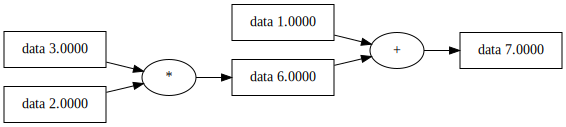

In [5]:
from graphviz import Digraph


def get_nodes_and_edges(root: Value) -> tuple[set, set]:
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dag(root: Value, format='svg', rankdir='LR'):
    assert rankdir in ['LR', 'TB']
    nodes, edges = get_nodes_and_edges(root)
    dag = Digraph(format=format, graph_attr={'rankdir': rankdir})
    
    for node in nodes:
        uid = str(id(node))
        dag.node(name=str(id(node)), label = "{ data %.4f }" % (node.data), shape='record')
        if node.operation:
            dag.node(name=str(id(node)) + node.operation, label=node.operation)
            dag.edge(str(id(node)) + node.operation, str(id(node)))
    
    for node_1, node_2 in edges:
        dag.edge(str(id(node_1)), str(id(node_2)) + node_2.operation)
        
    return dag


a = Value(2.0)
b = Value(3.0)
c = Value(1.0)
d: Value = (a * b) + c

print('a:', a)
print('b:', b)
print('c:', c)
print('d:', d)

draw_dag(d)

We now add a label parameter to the Value class so that each node can keep track of its corresponding variable name:

In [6]:
class Value:
    def __init__(self, data=None, children=(), operation='', label=''):
        self.data = data
        self.children = set(children)
        self.operation = operation
        self.label = label

    def __add__(self, other):
        result = Value(self.data + other.data, (self, other), operation='+')
        return result
    
    def __mul__(self, other):
        result = Value(self.data * other.data, (self, other), operation='*')
        return result

    def __repr__(self):
        return f"Value(data={self.data})"

and we update our drawing function accordingly:

a: Value(data=2.0)
b: Value(data=3.0)
c: Value(data=4.0)
d: Value(data=6.0)


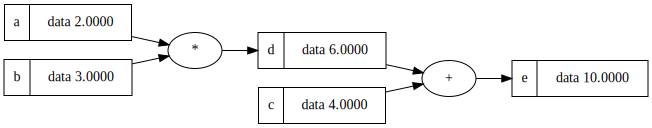

In [7]:
def get_nodes_and_edges(root: Value) -> tuple[set, set]:
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dag(root: Value, format='svg', rankdir='LR'):
    assert rankdir in ['LR', 'TB']
    nodes, edges = get_nodes_and_edges(root)
    dag = Digraph(format=format, graph_attr={'rankdir': rankdir})
    
    for node in nodes:
        uid = str(id(node))
        dag.node(name=uid, label = "{ %s | data %.4f }" % (node.label, node.data), shape='record')
        if node.operation:
            dag.node(name=str(id(node)) + node.operation, label=node.operation)
            dag.edge(str(id(node)) + node.operation, str(id(node)))
    
    for node_1, node_2 in edges:
        dag.edge(str(id(node_1)), str(id(node_2)) + node_2.operation)
        
    return dag

a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = Value(4.0, label='c')
d: Value = (a * b) 
d.label = 'd'
e: Value = c + d
e.label = 'e'
    
print('a:', a)
print('b:', b)
print('c:', c)
print('d:', d)

draw_dag(e)

So far, we can do a *forward pass* where we compute an output given some inputs. However, we also need to do *backwards pass* where we ask how the final result is affected if we make a small tweak to any of the nodes in the graph. 

In the context of a neural network, the input nodes correspond to the *weights* of the neural network and the output node corresponds to the loss function that specifies how well a given neural network is performing. In that context, the derivative of the loss function with respect to each of the weights indicates how much each weight contributes to the loss function, and therefore how much the given weight should be changed to decrease the loss function.

We can store the derivative of the loss function with respect to a given input as the property named `grad`, which is initialized to 0:

In [8]:
class Value:
    def __init__(self, data=None, children=(), operation='', label=''):
        self.data = data
        self.children = set(children)
        self.operation = operation
        self.label = label
        self.grad = 0.0

    def __add__(self, other):
        result = Value(self.data + other.data, (self, other), operation='+')
        return result
    
    def __mul__(self, other):
        result = Value(self.data * other.data, (self, other), operation='*')
        return result

    def __repr__(self):
        return f"Value(data={self.data})"

We update our drawing functions to incorporate the gradient:

a: Value(data=2.0)
b: Value(data=3.0)
c: Value(data=4.0)
d: Value(data=6.0)


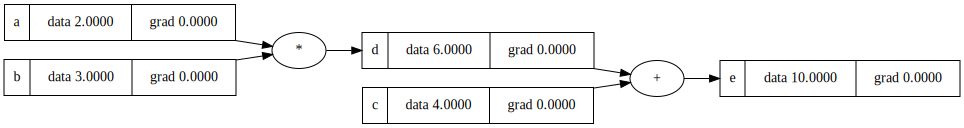

In [9]:
def get_nodes_and_edges(root: Value) -> tuple[set, set]:
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dag(root: Value, format='svg', rankdir='LR'):
    assert rankdir in ['LR', 'TB']
    nodes, edges = get_nodes_and_edges(root)
    dag = Digraph(format=format, graph_attr={'rankdir': rankdir})
    
    for node in nodes:
        uid = str(id(node))
        dag.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (node.label, node.data, node.grad), shape='record')
        if node.operation:
            dag.node(name=str(id(node)) + node.operation, label=node.operation)
            dag.edge(str(id(node)) + node.operation, str(id(node)))
    
    for node_1, node_2 in edges:
        dag.edge(str(id(node_1)), str(id(node_2)) + node_2.operation)
        
    return dag


a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = Value(4.0, label='c')
d: Value = (a * b) 
d.label = 'd'
e: Value = c + d
e.label = 'e'
    
print('a:', a)
print('b:', b)
print('c:', c)
print('d:', d)

draw_dag(e)

In the context of a neural network, a more realistic example might look as follows:

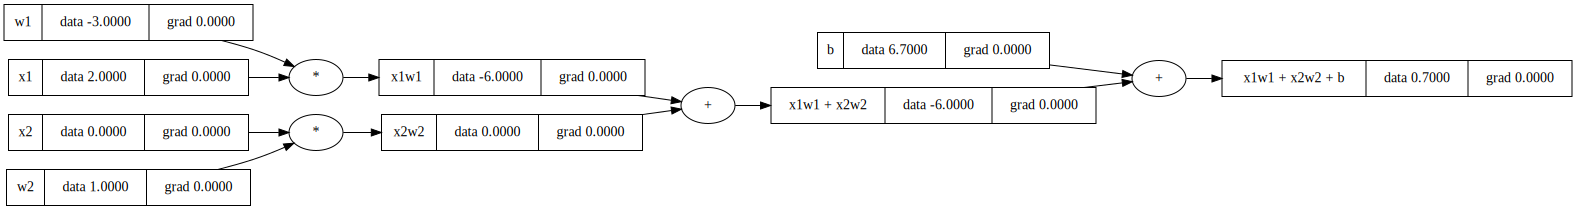

In [10]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.7, label='b')


x1w1 = x1 * w1
x1w1.label = 'x1w1'
x2w2 = x2 * w2
x2w2.label = 'x2w2'

dot_product = x1w1 + x2w2
dot_product.label = 'x1w1 + x2w2'

dot_product_with_bias = dot_product + b
dot_product_with_bias.label = 'x1w1 + x2w2 + b'

draw_dag(dot_product_with_bias)

To complete the forward pass, we need to implement an activation function such as the hyperbolic tangent function. We can add that to our class as follows:

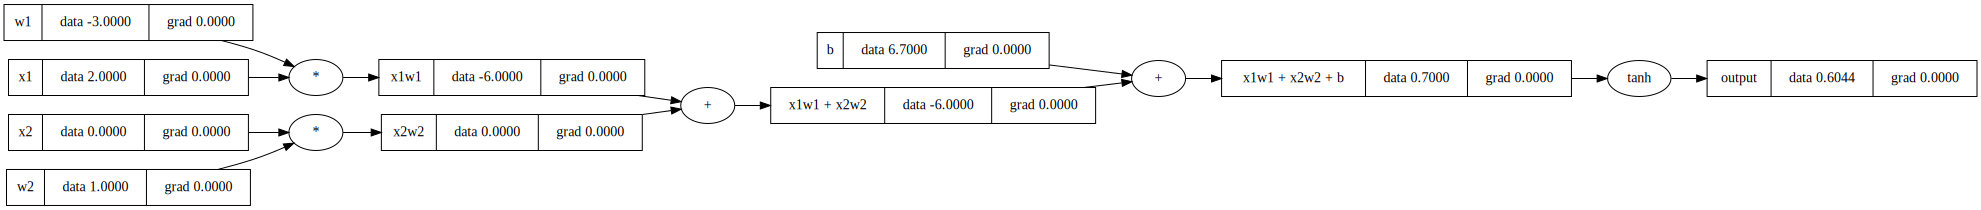

In [11]:
from math import exp


class Value:
    def __init__(self, data=None, children=(), operation='', label=''):
        self.data = data
        self.children = set(children)
        self.operation = operation
        self.label = label
        self.grad = 0.0

    def __add__(self, other):
        result = Value(self.data + other.data, (self, other), operation='+')
        return result
    
    def __mul__(self, other):
        result = Value(self.data * other.data, (self, other), operation='*')
        return result
    
    def tanh(self) -> float:
        x = self.data
        result = (exp(x)-exp(-x)) / (exp(x)+exp(-x))
        return Value(result, (self, ), 'tanh')


    def __repr__(self):
        return f"Value(data={self.data})"


x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.7, label='b')


x1w1 = x1 * w1
x1w1.label = 'x1w1'
x2w2 = x2 * w2
x2w2.label = 'x2w2'

dot_product = x1w1 + x2w2
dot_product.label = 'x1w1 + x2w2'

dot_product_with_bias = dot_product + b
dot_product_with_bias.label = 'x1w1 + x2w2 + b'

nn_output: Value = dot_product_with_bias.tanh()
nn_output.label = 'output'

draw_dag(nn_output)

To automate the backward pass, each time we reach a node which is the output of two other nodes, we compute the derivative of the output node with respect to each of the input nodes, and store the corresponding *function* called *backwards* on each input node:

In [12]:
class Value:
    def __init__(self, data=None, children=(), operation='', label=''):
        self.data = data
        self.grad = 0.0
        
        self.backward = lambda: None
        self.children = set(children)
        self.operation = operation
        self.label = label

    
    def __add__(self, other):
        result = Value(self.data + other.data, (self, other), operation='+')
        def backward() -> None:
            self.grad = result.grad
            other.grad = result.grad
        
        result.backward = backward
        return result
    
   
    def __mul__(self, other):
        result = Value(self.data * other.data, (self, other), operation='*')

        def backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        
        result.backward = backward
        return result
    

    def tanh(self) -> float:
        x = self.data
        result = (exp(x)-exp(-x)) / (exp(x)+exp(-x))
        hyperbolic_tangent = Value(result, (self, ), 'tanh')

        def backward():
            self.grad = (1 - result ** 2) * result.grad
        
        hyperbolic_tangent.backward = backward
        return hyperbolic_tangent
    

    def __repr__(self):
        return f"Value(data={self.data})"

each time we evaluate the derivative of a node, we need to make sure we have already evaluated all of the upstream derivatives from that node. We can impose the required order on the DAG using topological sort. 

The final result looks as follows:

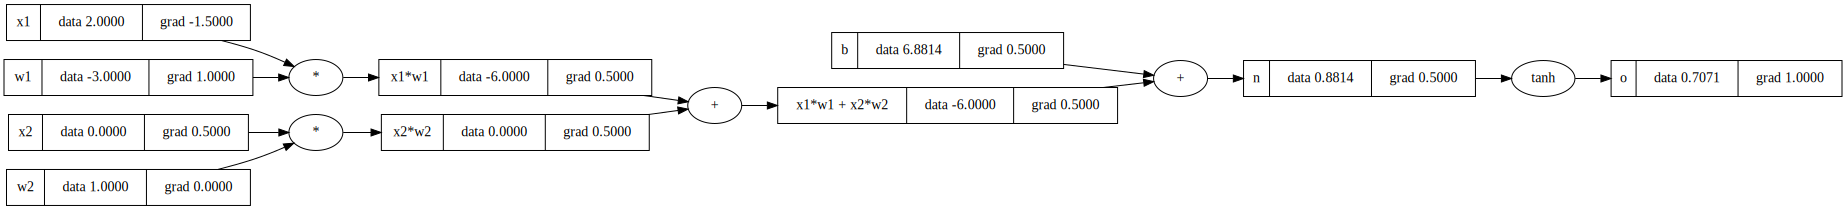

In [13]:
import math


class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(
            other, (int, float)
        ), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __radd__(self, other):  # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += (
                out.data * out.grad
            )  # NOTE: in the video I incorrectly used = instead of +=. Fixed here.

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


# inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1,w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.8813735870195432, label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"
o.backward()
draw_dot(o)


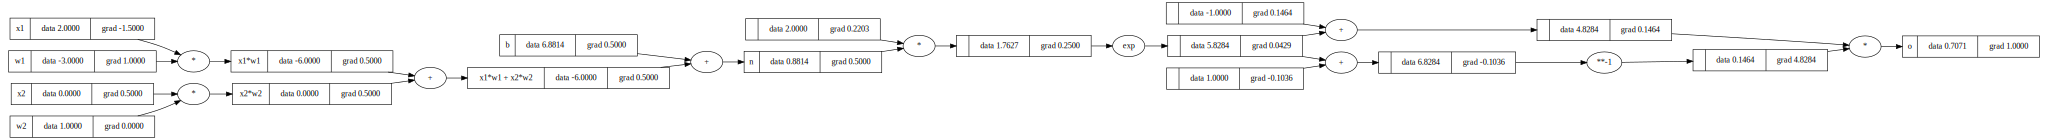

In [14]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

We can do the same thing in pytorch more concisely as follows:

In [15]:
import torch
from torch import Tensor


x1 = Tensor([2.0]).double()
x1.requires_grad = True
x2 = Tensor([0.0]).double()
x2.requires_grad = True
w1 = Tensor([-3.0]).double()
w1.requires_grad = True
w2 = Tensor([1.0]).double()
w2.requires_grad = True
b = Tensor([6.8813735870195432]).double()
b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print('output of neural net:', o.data.item())
o.backward()

print('gradient of x1:', x1.grad.item())
print('gradient of x2:', x2.grad.item())
print('gradient of w1:', w1.grad.item())
print('gradient of w2:', w2.grad.item())

output of neural net: 0.7071066904050358
gradient of x1: -1.5000003851533106
gradient of x2: 0.5000001283844369
gradient of w1: 1.0000002567688737
gradient of w2: 0.0


the above example was artificial in the sense that it is limited to individual scalar values. pytorch generally uses tensors of scalar values for efficiency instead of individual scalar values.